In [85]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, HDBSCAN
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
import matplotlib.pyplot as plt

## Load data

In [86]:
df = pd.read_csv("https://storage.googleapis.com/superlinked-notebook-user-acquisiton-analytics/user_acquisiton_data.csv")

## Scatterplot for numerical variables

<Axes: xlabel='signup_date', ylabel='activity'>

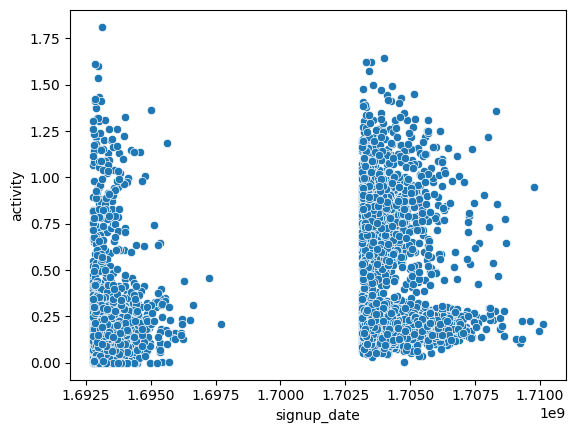

In [87]:
sns.scatterplot(x=df["signup_date"], y=df["activity"], data=df)

## Text vectorization

The ad_creative variables are sentences, and they are all trying to sell the same service. There are some apparent similarities between them so vectorization through text embedding looks logical (can capture much better the meaning of the sentences than treating them as simple categorical variables and using a much simpler encoding)

In [88]:
sentences = df["ad_creative"].unique().tolist()
sentences

['Join a dynamic gaming universe where every challenge pushes your skills to the limit! Connect with like-minded gamers and conquer the virtual realm together!',
 'Join a thriving gaming community and challenge your skills against formidable opponents!',
 'Experience the rush of competitive gaming! Join now to connect with fellow gamers and test your mettle in epic battles!',
 'Step into the arena of endless possibilities! Join now to engage in exhilarating gaming competitions and forge friendships with fellow gamers along the way!',
 'Enter the realm of gaming excellence! Join our vibrant community and compete against some of the most skilled players worldwide!',
 'Seeking thrilling gaming adventures? Join our community of gamers and embark on epic quests against worthy adversaries!',
 'Unleash your gaming potential! Upgrade to premium for 2 months free and dominate the competition with XYZCr$$d!',
 'Embark on your gaming journey with XYZCr$$d! Join now and experience the thrill of co

For text embedding the all-mpnet-base-v2 sentence-transformer model is used from the sentence-transformers framework. (https://huggingface.co/sentence-transformers/all-mpnet-base-v2)

Each sentence will be represented with a vector of length 768

In [89]:
embedding_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

embeddings = embedding_model.encode(sentences)

In [90]:
# merge with df
embeddings_df = pd.DataFrame({"ad_creative": df["ad_creative"].unique()})
embeddings_df = pd.concat([embeddings_df, pd.DataFrame(embeddings)], axis=1)

df = pd.merge(df, embeddings_df, on="ad_creative")

## Scaling variables

To rescale the variables I am using StandardScaler from sklearn, which standarizes the data.

In [92]:
# Drop id and ad_creative -> no need to rescale them, not used in clustering
df = df.drop(columns=["id", "ad_creative"])

df.columns = df.columns.astype(str)  # scaler didn't work with int column names

In [26]:
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df))

# Clustering

## HDBSCAN

In [118]:
hdbscan = HDBSCAN(min_cluster_size=300, min_samples=15)
hdbscan_clusters = hdbscan.fit_predict(scaled_df)

First, I ran the HDBSCAN with the following parameters: min_cluster_size=100, min_samples=15. This produced 18 clusters and left some observations unclustered. I felt like 18 clusters might be a bit too much, so I increased the min_cluster_size gradually so that the clustering doesn't include very small clusters and ended at 300.

min_cluster_size=100, min_samples=15 parameters produced 12 clusters and left 64 observations unclustered

## DBSCAN

In [126]:
dbscan_clusters = DBSCAN(eps=0.5, min_samples=200).fit_predict(scaled_df)

Running DBSCAN with eps=0.5, min_samples=100 resulted in 17 clusters and left 1072 observations unclustered. I DBSCAN leaves more data points unclustered, since it can't make clusters with different densities. I considered 17 clusters to be too many, so I increased min_samples to 200. This way 12 clusters were produced but more than 2000 observations were not sorted into clusters

In [124]:
df["hdbscan_clusters"] = hdbscan_clusters
df["hdbscan_clusters"].value_counts()

hdbscan_clusters
 10    1421
 9     1312
 8     1014
 6      671
 7      541
 4      533
 3      501
 5      501
 0      452
 1      347
 2      343
 11     300
-1       64
Name: count, dtype: int64

In [127]:
df["dbscan_clusters"] = dbscan_clusters
df["dbscan_clusters"].value_counts()

dbscan_clusters
-1     2065
 6     1445
 9     1073
 7      596
 10     428
 8      397
 4      382
 0      334
 2      318
 1      244
 3      243
 5      243
 11     232
Name: count, dtype: int64

## Plotting via UMAP

In [135]:
umap_data = umap.UMAP(
    n_neighbors=10, min_dist=0.5, metric='euclidean'
).fit_transform(scaled_df)

c:\Users\aronn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


For the UMAP after trying out different parameters I ended up going with n_neighbors=10 and min_dist=0.5. The reason I chose these is that this looked the best in my opinion.

In [136]:
umap_data = pd.DataFrame(umap_data, columns=["x", "y"])
umap_data = umap_data.assign(
    hdbscan_clusters=df["hdbscan_clusters"], dbscan_clusters=df["dbscan_clusters"]
)

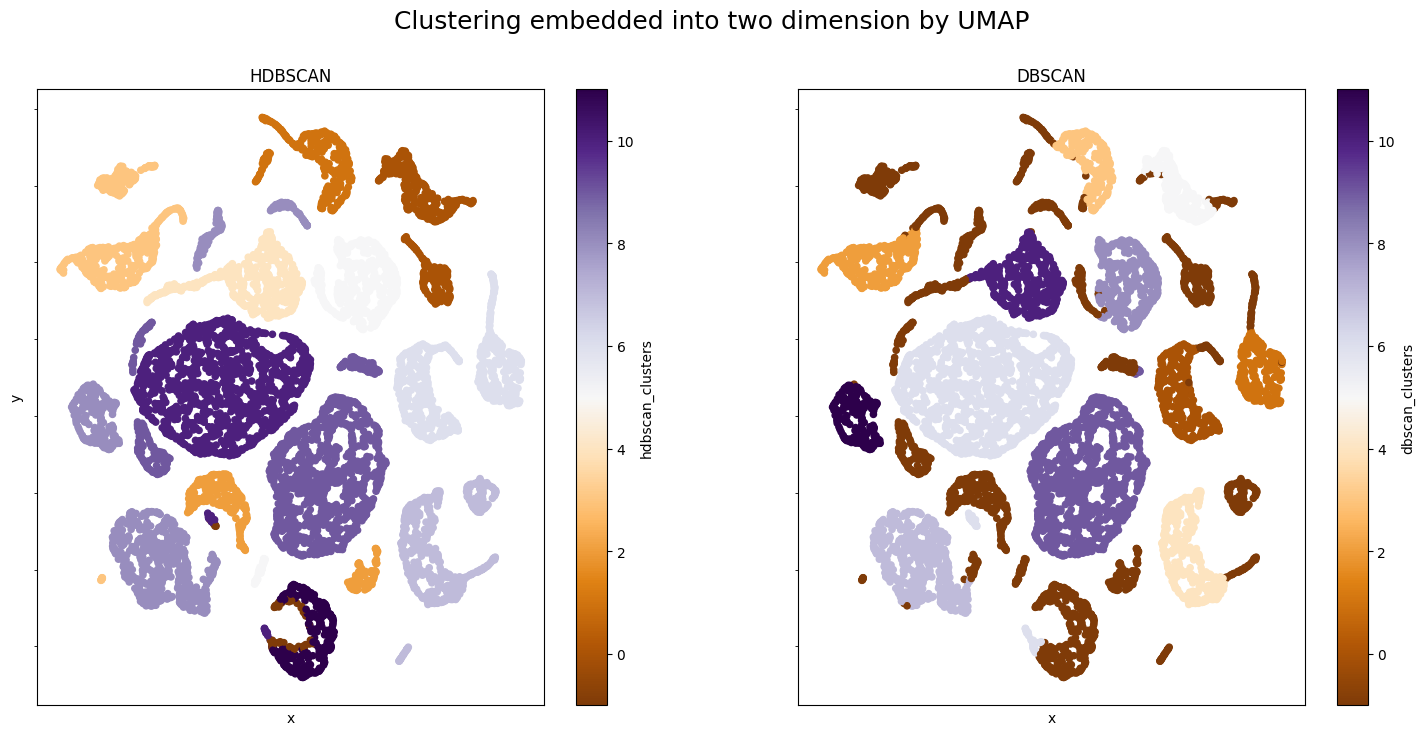

In [137]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(18, 8))
umap_data.plot.scatter(x="x", y="y", c="hdbscan_clusters", ax=ax[0], cmap="PuOr")
umap_data.plot.scatter(x="x", y="y", c="dbscan_clusters", ax=ax[1], cmap="PuOr")
plt.suptitle("Clustering embedded into two dimension by UMAP", fontsize=18)
plt.setp(ax[0], xticks=[], yticks=[])
plt.setp(ax[1], xticks=[], yticks=[])
ax[0].set_title("HDBSCAN", fontsize=12)
ax[1].set_title("DBSCAN", fontsize=12)
plt.show()

My take away from this little clustering task is that clustering is hard or at least it is hard to decide when did we arrive at a sufficiently good clustering. Since I had very limited knowledge of what the data represents it is impossible to use domain knowledge (not that I would have many) to judge how many clusters do we expect/want. Is it beneficial to have a lot of small clusters or we would like to have fewer bigger ones (we talked about this trade-off in class).

The task is further complicated by the high-cardinality of the data. It is impossible to visualize the data and the clusters so we need a dimensionality reduction technique like UMAP. While visualizing the clusters those give us some information about them, it also can be misleading (I thought about the possibility of getting a very bad clustering in high dimensions to look good in 2D by tinkering with the UMAP parameters).